In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_csv('../Input/Books_rating.csv')
df['time'] = pd.to_datetime(df['time'], unit='s')
print('shape: ',df.shape)
df.head()

shape:  (3000000, 9)


,Id,Title,Price,User_id,profileName,score,time,summary,text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",4.0,1999-10-23,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,5.0,2004-09-21,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,5.0,2004-03-09,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",4.0,2004-07-25,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",4.0,2005-02-10,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


# Summary Statistics

In [12]:
df[['Title','User_id']].describe(include='object')

,Title,User_id
count,2999792,2438213
unique,212403,1008972
top,The Hobbit,A14OJS0VWMOSWO
freq,22023,5795


In [29]:
df.describe()

,Price,score,time
count,481171.000000,3.000000e+06,3000000
mean,21.762656,4.215289e+00,2005-11-18 09:39:32.630393216
min,1.000000,1.000000e+00,1969-12-31 23:59:59
25%,10.780000,4.000000e+00,2001-09-08 00:00:00
50%,14.930000,5.000000e+00,2005-10-03 00:00:00
75%,23.950000,5.000000e+00,2010-03-21 00:00:00
max,995.000000,5.000000e+00,2013-03-04 00:00:00
std,26.206541,1.203054e+00,NaN


# Missing Data Analysis

In [43]:
missing_data = df.isnull().sum()
missing_data_percentage = (missing_data / len(df)) * 100

# Create a dataframe to better visualize missing data
missing_data_df = pd.DataFrame({
    'Missing Values': missing_data,
    'Percentage': missing_data_percentage
}).sort_values(by='Missing Values', ascending=False)

# Display missing data summary
print("Missing Data Analysis:")
print(missing_data_df)

Missing Data Analysis:
             Missing Values  Percentage
Price               2518829   83.960967
profileName          561905   18.730167
User_id              561787   18.726233
summary                 407    0.013567
Title                   208    0.006933
text                      8    0.000267
Id                        0    0.000000
time                      0    0.000000
score                     0    0.000000
quarter                   0    0.000000
year                      0    0.000000


In [30]:

print("\nMissing Data Analysis:")
print(df.isnull().sum())

# # Visualizing Missing Data
# plt.figure(figsize=(10, 6))
# sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
# plt.title('Missing Data Heatmap')
# plt.show()


Missing Data Analysis:
Id                   0
Title              208
Price          2518829
User_id         561787
profileName     561905
score                0
time                 0
summary            407
text                 8
dtype: int64


# Individual Variables

## Titles

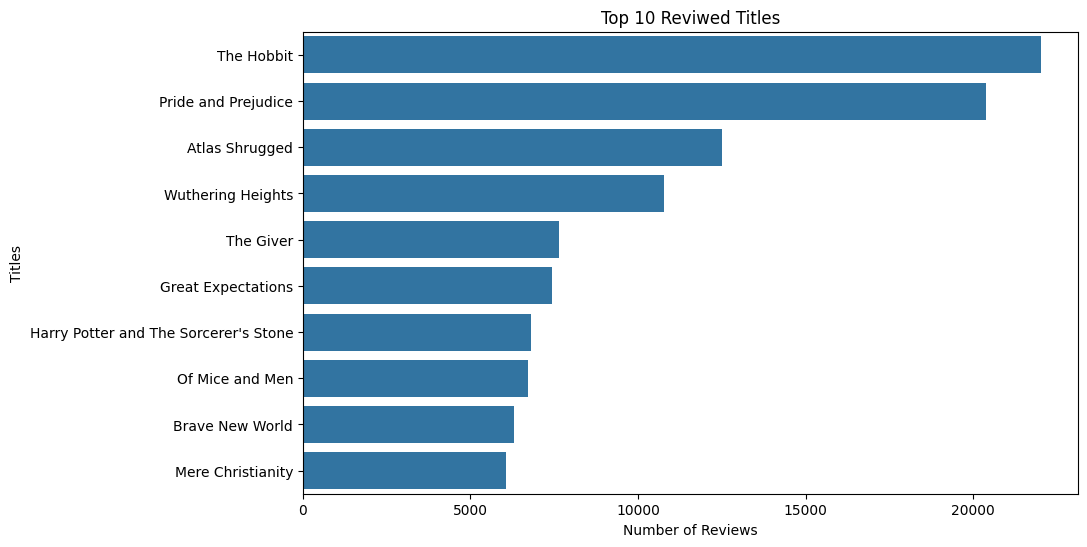

In [21]:
# Counting the number of books per author
title_counts = df['Title'].value_counts()


plt.figure(figsize=(10, 6))
sns.barplot(x=title_counts.head(10).values, y=title_counts.head(10).index)
plt.title('Top 10 Reviwed Titles')
plt.xlabel('Number of Reviews')
plt.ylabel('Titles')
plt.show()

## Reviwers

In [32]:
# # Counting the number of books per author
# title_counts = df['User_id'].value_counts()


# plt.figure(figsize=(10, 6))
# sns.barplot(x=title_counts.head(10).values, y=title_counts.head(10).index)
# plt.title('Top 10 Reviwed Titles')
# plt.xlabel('Number of Reviews')
# plt.ylabel('Titles')
# plt.show()

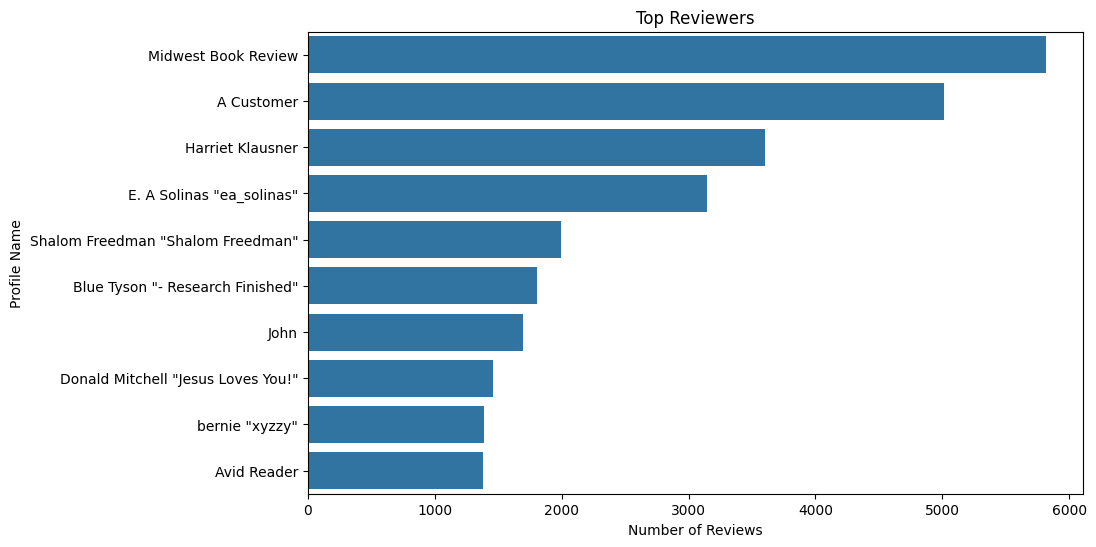

In [42]:
# Visualizing Top Reviewers
plt.figure(figsize=(10, 6))
sns.barplot(x=top_reviewers.values, y=top_reviewers.index)
plt.title('Top Reviewers')
plt.xlabel('Number of Reviews')
plt.ylabel('Profile Name')
plt.show()

## Distribution of Ratings

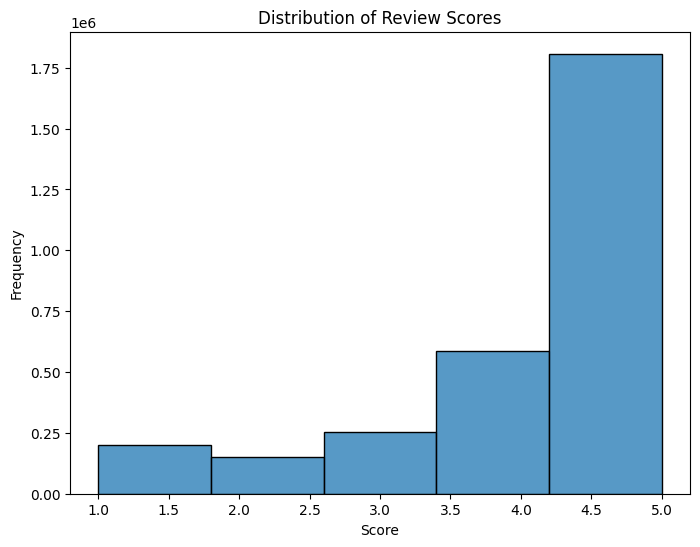

In [28]:
plt.figure(figsize=(8, 6))
sns.histplot(df['score'], bins=5)
plt.title('Distribution of Review Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

## Time

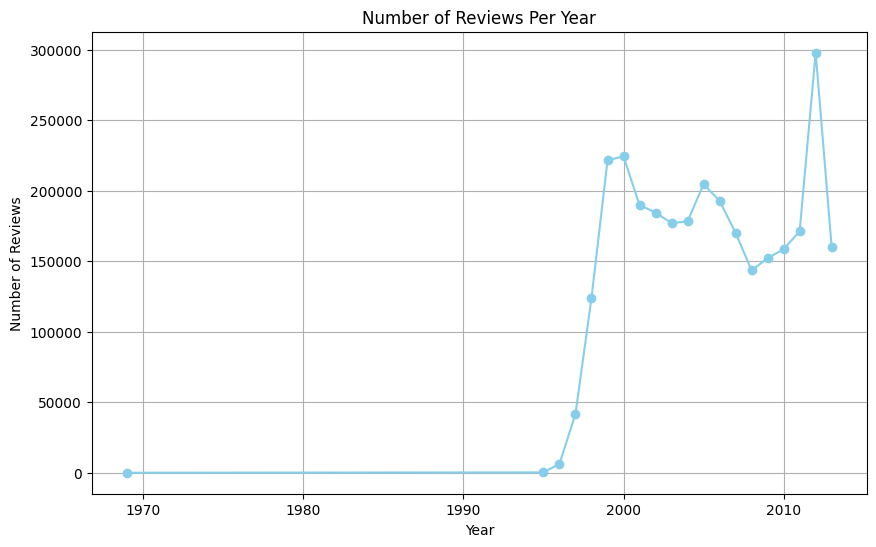

In [39]:
df['year'] = df['time'].dt.year

# Group by year and count the number of reviews
reviews_per_year = df.groupby('year').size()

# Plotting the number of reviews per year as a line plot
plt.figure(figsize=(10, 6))
plt.plot(reviews_per_year.index, reviews_per_year.values, marker='o', linestyle='-', color='skyblue')
plt.title('Number of Reviews Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.show()